In [1]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np


In [38]:
class KeypointDataset(Dataset):
    def __init__(self, json_file, transform=None):
        with open(json_file, 'r') as f:
            data = json.load(f)
        
        self.annotations = data['annotations']
        self.transform = transform
        self.keypoints = []
        self.categories = []
        
        for ann in self.annotations:
            # Extract 3D keypoints (reshape them to 21 x 3)
            keypoints = np.array(ann['keypoints'])  # Assuming the keypoints are stored flat
            if keypoints.shape[0] == 0:
                continue
            self.keypoints.append(keypoints.flatten())  # Flatten to a 1D array for input
            self.categories.append(ann['category_id'])
        
        # Normalize the keypoints if needed
        self.keypoints = np.array(self.keypoints)
        self.categories = np.array(self.categories)

    def __len__(self):
        return len(self.categories)

    def __getitem__(self, idx):
        keypoints = self.keypoints[idx]
        category = self.categories[idx]

        if self.transform:
            keypoints = self.transform(keypoints)
        
        return torch.tensor(keypoints, dtype=torch.float32), torch.tensor(category, dtype=torch.long)

In [80]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.mlp(x)

In [53]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1s = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for keypoints, labels in train_loader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluate on the validation set at the end of each epoch
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate_model_with_metrics(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # print(f"Epoch {epoch + 1}/{epochs}")
        # print(f"Train Loss: {avg_train_loss:.4f}")
        # print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1s

In [62]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate_model_with_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)
            outputs = model(keypoints)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    return avg_loss, accuracy, precision, recall, f1

In [60]:
import matplotlib.pyplot as plt

def plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs = 40):
    epochs = list(range(1, epochs+1))
    metrics = {
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Validation Accuracy": val_accuracies,
        "Validation Precision": val_precisions,
        "Validation Recall": val_recalls,
        "Validation F1 Score": val_f1
    }

    # Create subplots
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, 1, figsize=(10, 18), sharex=True)

    for i, (label, values) in enumerate(metrics.items()):
        axes[i].plot(epochs, values, label=label, marker='o')
        axes[i].set_title(label)
        axes[i].set_ylabel(label)
        axes[i].grid(True)
        axes[i].legend()

    # Set common X label
    plt.xlabel("Epochs")
    plt.tight_layout()
    plt.show()


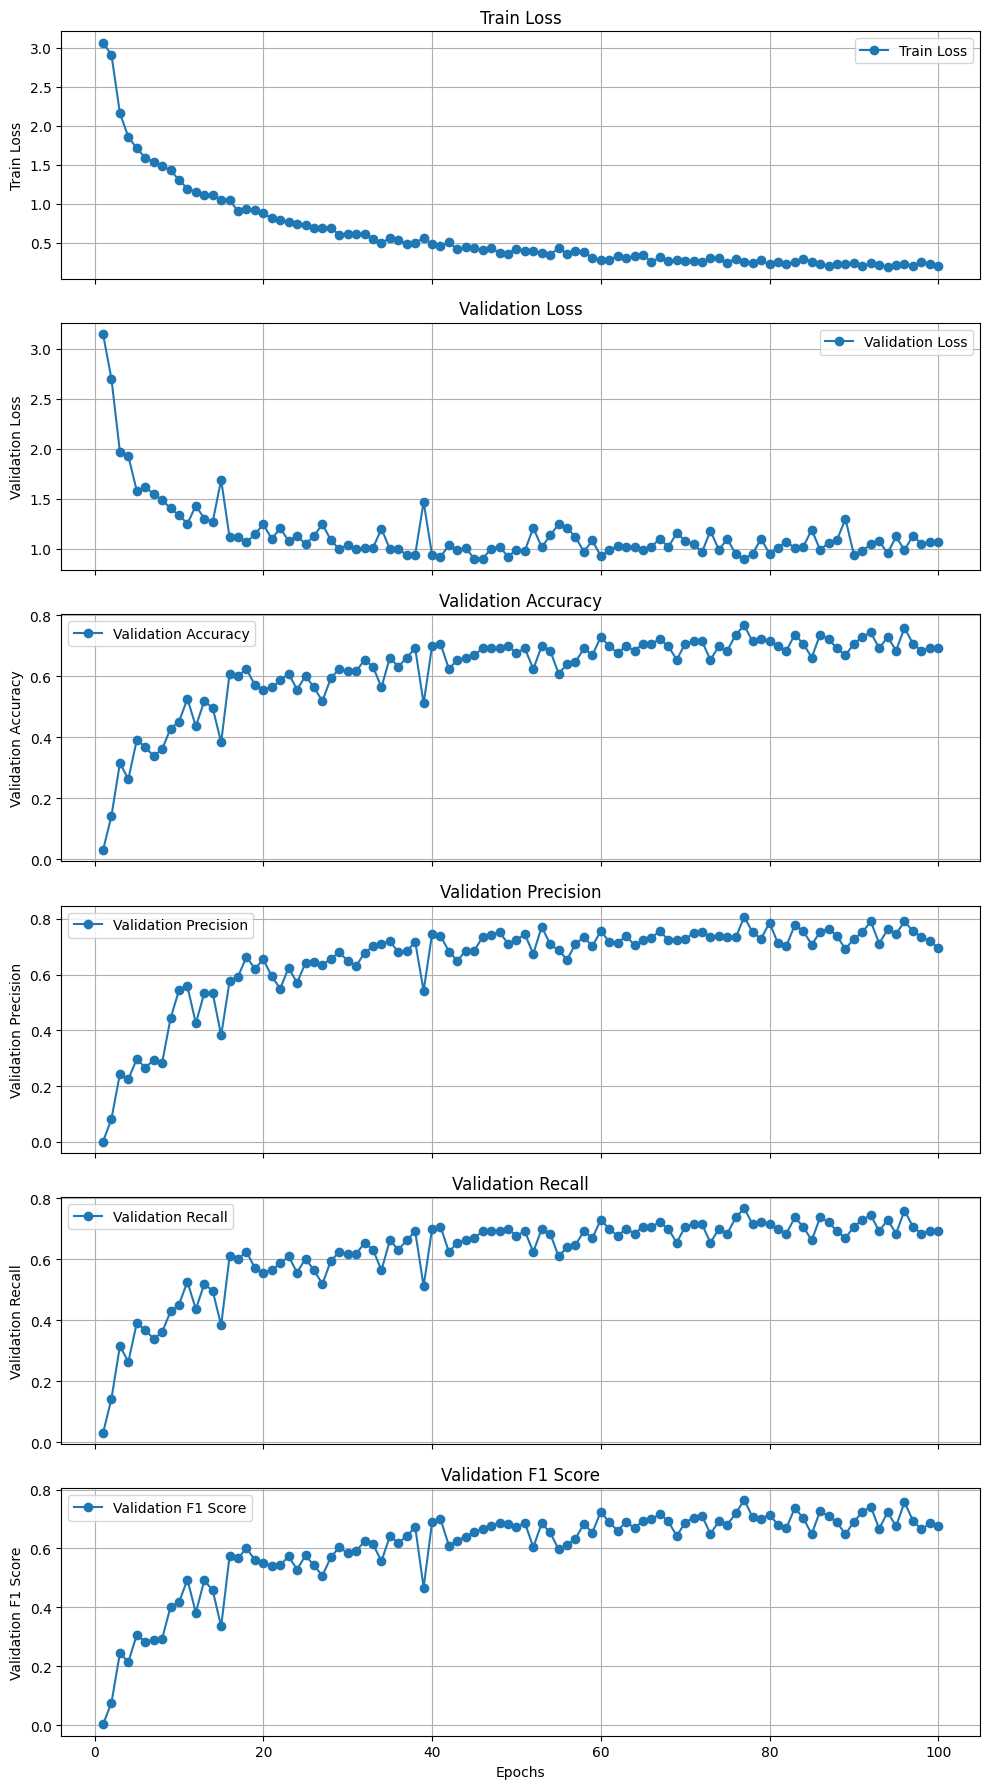

In [81]:
train_json = "train/_mediapipe_annotated.json"
val_json = "valid/_mediapipe_annotated.json"
test_json = "test/_mediapipe_annotated.json"
input_dim = 63  # 21 keypoints * 3 coordinates
hidden_dim = 256
num_classes = 26  # Adjust based on your dataset
batch_size = 16
learning_rate = 0.001
weight_decay = 0.001
epochs = 100
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Dataset and DataLoader
train_dataset = KeypointDataset(train_json)
val_dataset = KeypointDataset(val_json)
test_dataset = KeypointDataset(test_json)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# Model, Loss, Optimizer
model = MLPModel(input_dim, hidden_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay = weight_decay)

# Train and Evaluate
train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1 = train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs)

plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1, epochs)
# evaluate_model(model, val_loader, device)

In [82]:
torch.save(model, "mlp_model.pth")


In [55]:
print(train_losses)
print(val_losses)
print(val_accuracies)
print(val_precisions)
print(val_recalls)
print(val_f1)

[3.073068279969065, 2.9870294834438122, 2.630416851294668, 2.080302025142469, 1.8039563674675791, 1.6728642457409908, 1.603877161678515, 1.505502324355276, 1.518374126208456, 1.4515554622599953, 1.4639950676968223, 1.4046971892055713, 1.344222151919415, 1.3233775402370251, 1.3310734002213729, 1.2886779198521061, 1.230788169722808, 1.1553291600001485, 1.1114136717821423, 1.0972445403274738, 1.059555610543803, 1.0197803111452806, 0.9706484691092843, 0.9474748373031616, 0.9373358911589572, 0.8942977158646834, 0.8927572730340456, 0.8263061140712938, 0.8069896666627181, 0.7969063167509279, 0.7954162861171522, 0.7851524588308836, 0.7395525809965635, 0.7263326903707102, 0.7349580832217869, 0.7980417428832305, 0.6966214360375154, 0.6498969675678956, 0.6421024124873312, 0.6274317032412479]
[3.1705978393554686, 3.0348811626434324, 2.371771001815796, 2.067982721328735, 1.806123399734497, 1.682140588760376, 1.6718462467193604, 1.581818413734436, 1.6044005155563354, 1.714678907394409, 1.77670376300

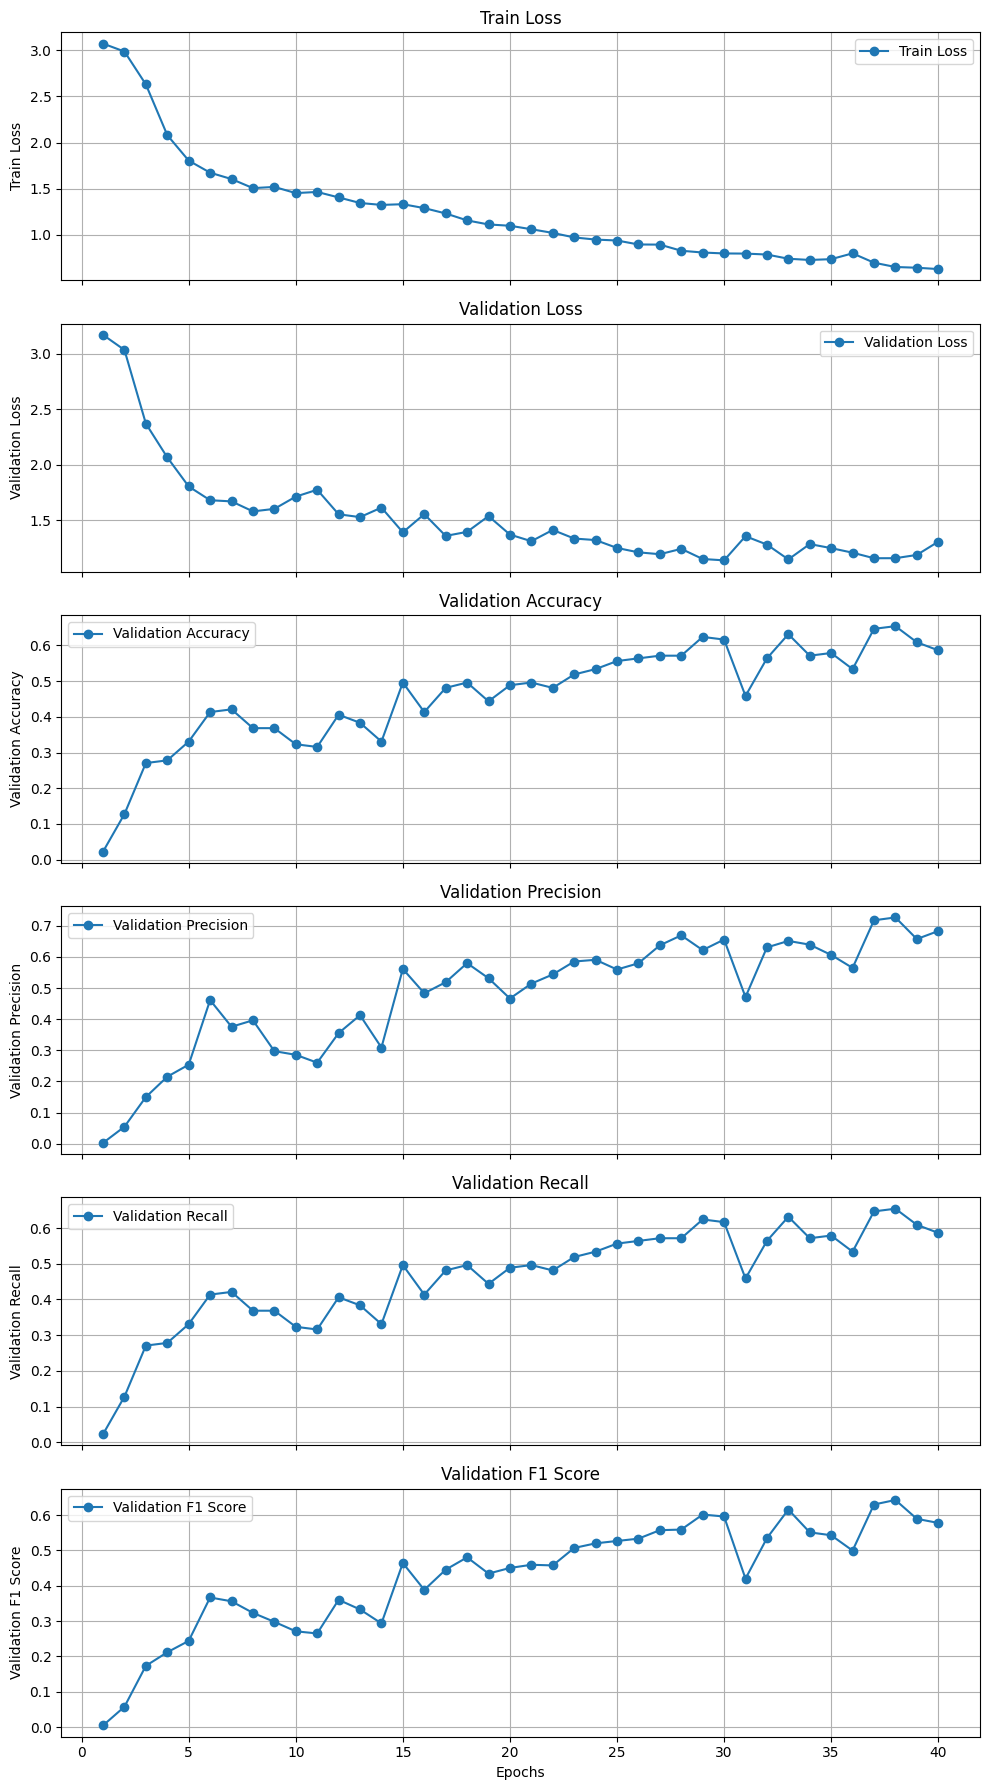

In [61]:
plot(train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1)

In [83]:
torch.save(model.state_dict(), "mlp_model.pth")

{'id': 0, 'license': 1, 'file_name': 'U7_jpg.rf.0037faea78f8a89329a93006132921b3.jpg', 'height': 390, 'width': 390, 'date_captured': '2020-10-20T16:55:24+00:00'}


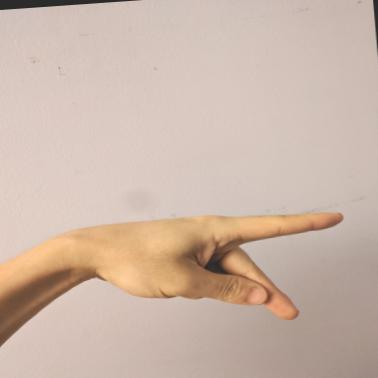

In [34]:
images = data['images']
print(images[0])

from PIL import Image
from IPython.display import display
import os

# Load the image
image_path = images[38]['file_name']  # Replace with your image path
img = Image.open("train/" + image_path)

# Display the image
display(img)